Nama : Muhammad Dhiauddin

NIM : 25917024

Program : Magister Informatika

Konsentrasi : Sains Data – Profesional

Domain : Kesehatan

Studi Kasus : Rumah Sakit Umum Daerah Datu Sanggul

# Tree-Based Algorithm ML Analysis for BPJS Antrol Patients

This notebook performs machine learning analysis on BPJS antrol patients data using tree-based algorithms to predict patient outcomes or patterns. It's designed specifically for Google Colab execution with CSV data from the database folder.

## Proyek Klasifikasi (Supervised Learning)
Tujuan: "Analisis Komperenshif Identifikasi Pendaftaran Pasien BPJS Add Antroll"
Kasus: Analisis Klasifikasi Pasien BPJS Add Antrol

### Persyaratan Proyek:
- Definisi Masalah: Membantu manajemen rumah sakit memahami pola pendaftaran pasien BPJS dan memprediksi jenis pembayaran atau status kunjungan pasien berdasarkan data pendaftaran.
- Kompleksitas Dataset: Dataset yang diproses memiliki campuran fitur numerik dan kategorikal serta menunjukkan proses preprocessing yang kompleks.

# 1. Understanding Business: Memahami kebutuhan bisnis dan tujuan analisis

## Permasalahan Utama:
Analisis pola keberhasilan dan kegagalan pendaftaran pasien BPJS melalui dua kanal yaitu Anjungan Pendaftaran Mandiri (APM) dan aplikasi Mobile JKN. Melalui pendekatan analisis log dan metode clustering dalam penerapan machine learning dengan menggunakan Tree-Based Algorithm : Decision Tree, Random Forest dan Gradient Boosting. bertujuan untuk mengidentifikasi faktor-faktor penyebab dan memberikan rekomendasi peningkatan efektivitas pelayanan digital rumah sakit.

Secara tidak optimalnya proses pendaftaran pasien BPJS pada kanal APM dan Mobile JKN karena adanya variasi tingkat keberhasilan dan kegagalan pengiriman data (status_kirim) yang menunjukkan pola berbeda, namun belum dianalisis secara komprehensif.

## Kebutuhan Bisnis:
1. Memahami faktor-faktor yang mempengaruhi keberhasilan pendaftaran BPJS melalui APM dan Mobile JKN
2. Mengidentifikasi pola kegagalan pendaftaran untuk perbaikan sistem
3. Memberikan rekomendasi untuk meningkatkan efektivitas layanan digital rumah sakit
4. Membantu manajemen dalam pengambilan keputusan terkait layanan pendaftaran pasien BPJS

## Tujuan Analisis:
- Mengklasifikasikan keberhasilan/kegagalan pendaftaran pasien BPJS berdasarkan berbagai faktor
- Menganalisis perbedaan pola pendaftaran antara kanal APM dan Mobile JKN
- Mengidentifikasi variabel-variabel penting yang mempengaruhi keberhasilan pendaftaran
- Membangun model prediktif untuk membantu pengambilan keputusan

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# from database.database_connection import get_bpjs_antrol_data
# from config.config import Config
import sys,os
# sys.path.append(os.path.dirname(os.path.abspath(__file__)))
import logging
import joblib
from datetime import datetime, timedelta

# Add project root to Python path
NOTEBOOK_DIR = os.getcwd()
ROOT_DIR = os.path.abspath(os.path.join(NOTEBOOK_DIR, ".."))
sys.path.append(ROOT_DIR)

# image folder path
IMAGE_DIR = os.path.join(ROOT_DIR, "image")
os.makedirs(IMAGE_DIR, exist_ok=True)

print("Root DIR:", ROOT_DIR)
print("Notebook DIR:", NOTEBOOK_DIR)
print("Subfolders:", os.listdir(ROOT_DIR))
print("Image Dir:", IMAGE_DIR)

# Set up logging
CURRENT_DIR = os.getcwd()
ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, ".."))

# Lokasi folder logs
LOG_DIR = os.path.join(ROOT_DIR, "logs")
os.makedirs(LOG_DIR, exist_ok=True)

# File log absolut
LOG_FILE = os.path.join(LOG_DIR, "bpjs_antrol_analysis.log")
print("Logging to:", LOG_FILE)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(LOG_FILE),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(__name__)

logger.info("1. Understanding Business: Analyzing BPJS patient registration patterns to predict payment type or visit status")
logger.info("Business Goal: Help hospital management understand BPJS registration patterns and optimize resource allocation")

2025-11-20 16:38:58,711 - __main__ - INFO - 1. Understanding Business: Analyzing BPJS patient registration patterns to predict payment type or visit status
2025-11-20 16:38:58,712 - __main__ - INFO - Business Goal: Help hospital management understand BPJS registration patterns and optimize resource allocation


Root DIR: c:\Users\IT\data science\Tree Based Algorithm ML Add Antroll Patients BPJS
Notebook DIR: c:\Users\IT\data science\Tree Based Algorithm ML Add Antroll Patients BPJS\notebooks
Subfolders: ['.env', '.env.example', '.git', '.gitignore', '.venv', '.vscode', 'bpjs_add_antrol.py', 'config', 'database', 'docs', 'image', 'logs', 'nano.sh', 'notebooks', 'output', 'README.md', 'requirements.txt', 'src', 'test']
Image Dir: c:\Users\IT\data science\Tree Based Algorithm ML Add Antroll Patients BPJS\image
Logging to: c:\Users\IT\data science\Tree Based Algorithm ML Add Antroll Patients BPJS\logs\bpjs_antrol_analysis.log


# 2. Data Understanding: Menjelajahi dan memahami struktur data

In [50]:
def load_data_from_csv(file_path):
    """Load patient data from CSV file."""
    try:
        df = pd.read_csv(file_path)
        logger.info(f"Data loaded successfully from CSV: {file_path}, shape={df.shape}")
        return df
    except Exception as e:
        logger.error(f"Error loading CSV file {file_path}: {e}")
        raise


def load_data_flexible():
    """
    Flexible loader: Try database first, fall back to CSV.
    Safe for Google Colab (database module can be missing).
    """

    start_date = '2025-01-01'
    end_date = '2025-06-30'

# TRY DATABASE (if module exists)
    try:
        from database.database_connection import get_bpjs_antrol_data
        logger.info("Database module detected, attempting DB connection...")

        df = get_bpjs_antrol_data(start_date, end_date)
        logger.info(f"Loaded {len(df)} records from database.")
        return df
    
    except ImportError:
        logger.warning("Database module NOT found. Switching to CSV fallback.")
    
    except Exception as e:
        logger.warning(f"Database connection failed: {e}. Switching to CSV fallback.")

# FALLBACK TO CSV FILE
    possible_csv_paths = [
        os.path.join(os.getcwd(), "database", "bpjs antrol.csv"),    
        "/content/bpjs_antrol.csv",                                 
        "/content/database/bpjs_antrol.csv"                         
    ]

    for csv_path in possible_csv_paths:
        if os.path.exists(csv_path):
            logger.info(f"CSV detected at: {csv_path}")
            df = load_data_from_csv(csv_path)

            # Filter date range
            if 'tgl_registrasi' in df.columns:
                df['tgl_registrasi'] = pd.to_datetime(df['tgl_registrasi'], 
                                                      format='mixed', 
                                                      dayfirst=True, 
                                                      errors='coerce')

                df = df[
                    (df['tgl_registrasi'] >= start_date) &
                    (df['tgl_registrasi'] <= end_date)
                ]

                logger.info(f"Filtered CSV by date range → shape={df.shape}")

            return df

    # If all CSV paths fail
    raise FileNotFoundError(
        "Failed to load from DB and CSV file not found in:\n" +
        "\n".join(possible_csv_paths)
    )

logger.info("2. Data Understanding: Loading dataset...")

try:
    df = load_data_flexible()
except Exception as e:
    logger.error(f"Data loading failed: {e}")
    raise

logger.info(f"Dataset loaded successfully. Shape: {df.shape}")
logger.info(f"Columns: {list(df.columns)}")



2025-11-20 16:38:58,728 - __main__ - INFO - 2. Data Understanding: Loading dataset...
2025-11-20 16:38:58,729 - __main__ - INFO - Database module detected, attempting DB connection...
2025-11-20 16:38:58,731 - database.database_connection - INFO - Database engine created successfully
2025-11-20 16:42:29,149 - database.database_connection - INFO - Query executed successfully, returned 139403 rows
2025-11-20 16:42:29,150 - __main__ - INFO - Loaded 139403 records from database.
2025-11-20 16:42:29,275 - __main__ - INFO - Dataset loaded successfully. Shape: (139403, 20)
2025-11-20 16:42:29,276 - __main__ - INFO - Columns: ['no_rawat', 'tgl_registrasi', 'jam_reg', 'kd_dokter', 'nm_dokter', 'no_rkm_medis', 'nm_pasien', 'kd_poli', 'nm_poli', 'status_lanjut', 'kd_pj', 'png_jawab', 'tanggal_periksa', 'nomor_kartu', 'nomor_referensi', 'kodebooking', 'jenis_kunjungan', 'status_kirim', 'keterangan', 'USER']


# 3. Data Preparation / Wrangling: Menyiapkan dan mengolah data

In [51]:
def create_features(df):
    """Create additional features from the raw data"""
    df = df.copy()
    
    # Convert date columns to datetime if they exist
    date_columns = ['tgl_registrasi', 'tanggal_periksa']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Create additional features
    if 'tgl_registrasi' in df.columns:
        df['hari_registrasi'] = df['tgl_registrasi'].dt.day_name()
        df['bulan_registrasi'] = df['tgl_registrasi'].dt.month
        df['tahun_registrasi'] = df['tgl_registrasi'].dt.year
    
    if 'tanggal_periksa' in df.columns:
        df['hari_periksa'] = df['tanggal_periksa'].dt.day_name()
        df['bulan_periksa'] = df['tanggal_periksa'].dt.month
        df['tahun_periksa'] = df['tanggal_periksa'].dt.year

    # Calculate difference between registration and examination dates
    if 'tgl_registrasi' in df.columns and 'tanggal_periksa' in df.columns:
        df['hari_antara_reg_periksa'] = (df['tanggal_periksa'] - df['tgl_registrasi']).dt.days

    return df

logger.info("3. Data Preparation/Wrangling: Preparing and wrangling the dataset...")
logger.info(f"Original dataset shape: {df.shape}")
logger.info(f"Original dataset columns: {list(df.columns)}")

# Create additional features for better analysis
original_columns = set(df.columns)
df = create_features(df)
logger.info(f"Dataset shape after feature creation: {df.shape}")
new_columns = set(df.columns) - original_columns
if new_columns:
    logger.info(f"New columns added: {new_columns}")
else:
    logger.info("No new columns were added during feature creation")

2025-11-20 16:42:29,287 - __main__ - INFO - 3. Data Preparation/Wrangling: Preparing and wrangling the dataset...
2025-11-20 16:42:29,288 - __main__ - INFO - Original dataset shape: (139403, 20)
2025-11-20 16:42:29,289 - __main__ - INFO - Original dataset columns: ['no_rawat', 'tgl_registrasi', 'jam_reg', 'kd_dokter', 'nm_dokter', 'no_rkm_medis', 'nm_pasien', 'kd_poli', 'nm_poli', 'status_lanjut', 'kd_pj', 'png_jawab', 'tanggal_periksa', 'nomor_kartu', 'nomor_referensi', 'kodebooking', 'jenis_kunjungan', 'status_kirim', 'keterangan', 'USER']
2025-11-20 16:42:29,500 - __main__ - INFO - Dataset shape after feature creation: (139403, 27)
2025-11-20 16:42:29,501 - __main__ - INFO - New columns added: {'hari_periksa', 'tahun_registrasi', 'hari_registrasi', 'bulan_periksa', 'bulan_registrasi', 'hari_antara_reg_periksa', 'tahun_periksa'}


# 4. Data Cleaning: Membersihkan data dari ketidakkonsistenan

In [52]:
logger.info("4. Data Cleaning: Cleaning data from inconsistencies...")

# Check for missing values before cleaning
missing_before = df.isnull().sum()
logger.info(f"Missing values before cleaning:\n{missing_before[missing_before > 0]}")

# Remove duplicate rows
initial_count = len(df)
df = df.drop_duplicates()
duplicates_removed = initial_count - len(df)
if duplicates_removed > 0:
    logger.info(f"Removed {duplicates_removed} duplicate rows")
else:
    logger.info("No duplicate rows found")

# Handle missing values with more sophisticated approach
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['object', 'category']:
            # For categorical columns, fill with mode or 'Unknown'
            mode_value = df[col].mode()
            if not mode_value.empty:
                df[col].fillna(mode_value[0], inplace=True)
            else:
                df[col].fillna('Unknown', inplace=True)
        else:
            # For numerical columns, fill with median
            df[col].fillna(df[col].median(), inplace=True)

# Identify and handle potential outliers in numerical columns using IQR method
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numerical_cols:
    if col not in ['tahun_registrasi', 'tahun_periksa']:  # Exclude year columns from outlier detection
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        if outliers_count > 0:
            logger.info(f"Found {outliers_count} outliers in column '{col}'")
            # Note: We'll keep outliers for now but flag them for analysis

# Check for missing values after cleaning
missing_after = df.isnull().sum()
logger.info(f"Missing values after cleaning:\n{missing_after[missing_after > 0]}")

logger.info(f"Dataset shape after cleaning: {df.shape}")

2025-11-20 16:42:29,514 - __main__ - INFO - 4. Data Cleaning: Cleaning data from inconsistencies...
2025-11-20 16:42:29,797 - __main__ - INFO - Missing values before cleaning:
keterangan    24
dtype: int64
2025-11-20 16:42:30,509 - __main__ - INFO - Removed 6170 duplicate rows
C:\Users\IT\AppData\Local\Temp\ipykernel_4156\669227776.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value[0], inplace=True)
2025-11-20 16:42:30,834 - __main__ - INFO - Found 4569 outliers in column 'jam_reg'
2025-11-20 16:42:

# 5. Explanatory Data Analysis (EDA Deskriptif): Analisis deskriptif awal

2025-11-20 16:42:31,148 - __main__ - INFO - Initial EDA - Basic dataset information:
2025-11-20 16:42:31,150 - __main__ - INFO - Dataset shape: (133233, 27)
2025-11-20 16:42:31,150 - __main__ - INFO - Numerical columns summary:
2025-11-20 16:42:31,186 - __main__ - INFO - 
                         jam_reg  bulan_registrasi  tahun_registrasi  \
count                     133233     133233.000000          133233.0   
mean   0 days 09:11:53.676491559          3.438135            2025.0   
std    0 days 01:21:48.294923635          1.674819               0.0   
min              0 days 00:02:26          1.000000            2025.0   
25%              0 days 08:20:31          2.000000            2025.0   
50%              0 days 08:54:43          3.000000            2025.0   
75%              0 days 09:43:20          5.000000            2025.0   
max              0 days 23:00:00          6.000000            2025.0   

       bulan_periksa  tahun_periksa  hari_antara_reg_periksa  
count  133233.0

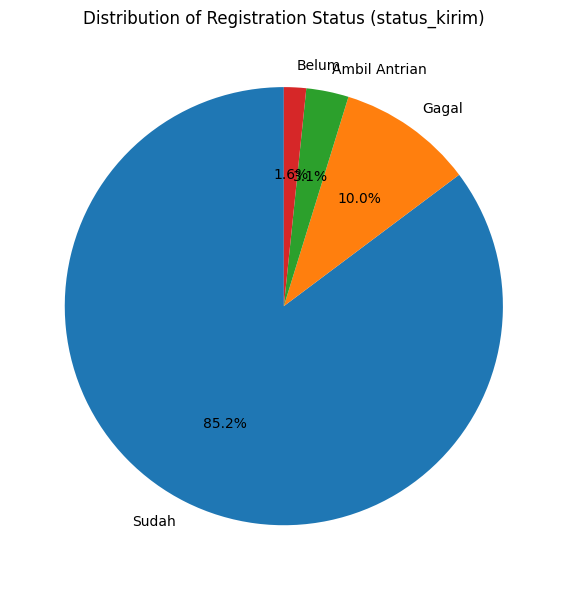

2025-11-20 16:42:32,130 - __main__ - INFO - Saved EDA visualization: eda_status_kirim.png


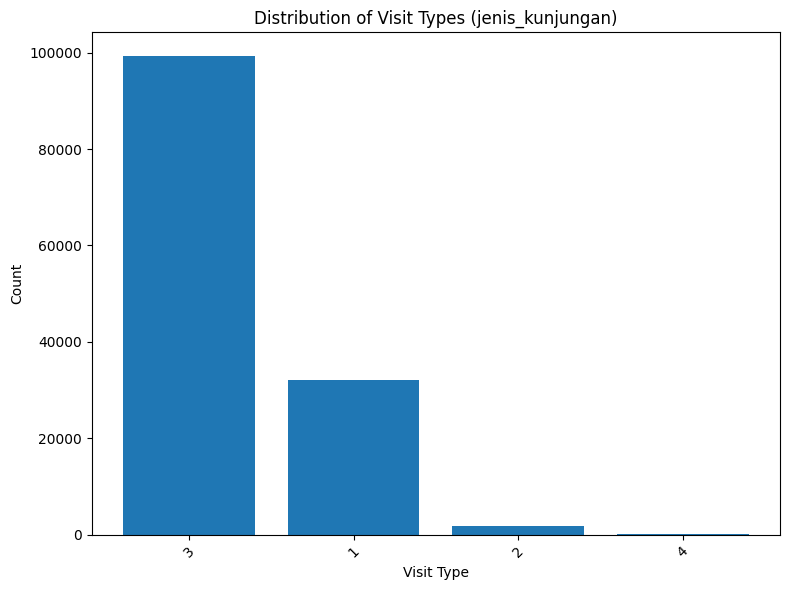

2025-11-20 16:42:32,376 - __main__ - INFO - Saved EDA visualization: eda_jenis_kunjungan.png


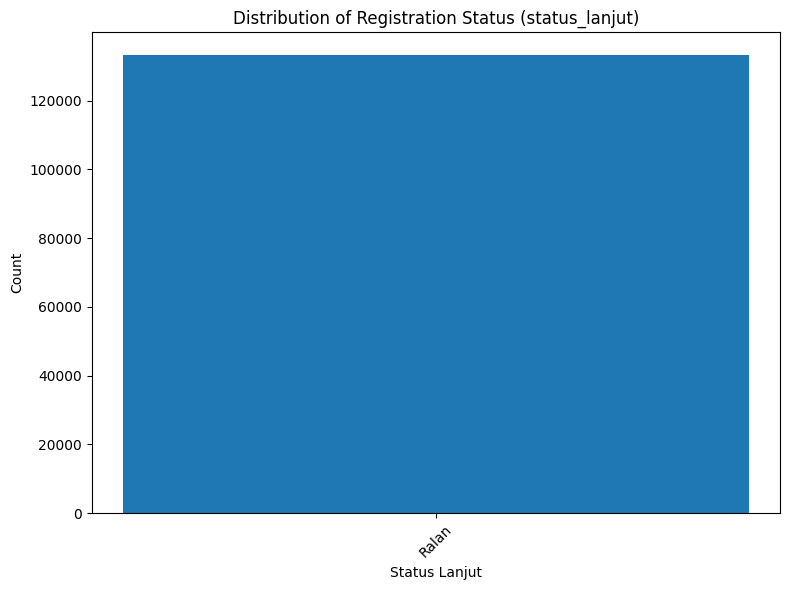

2025-11-20 16:42:32,545 - __main__ - INFO - Saved EDA visualization: eda_status_lanjut.png


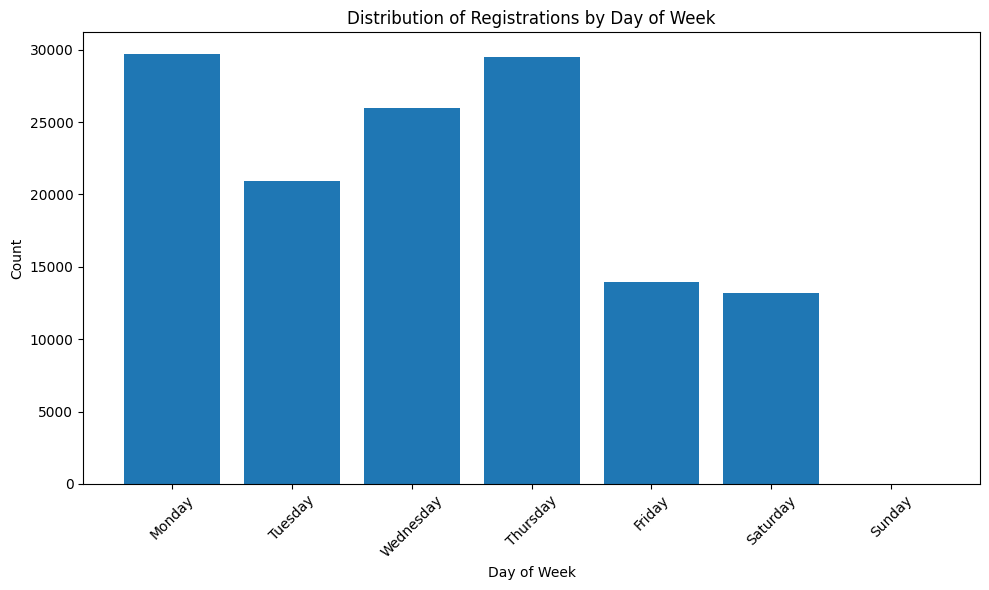

2025-11-20 16:42:32,849 - __main__ - INFO - Saved EDA visualization: eda_hari_registrasi.png


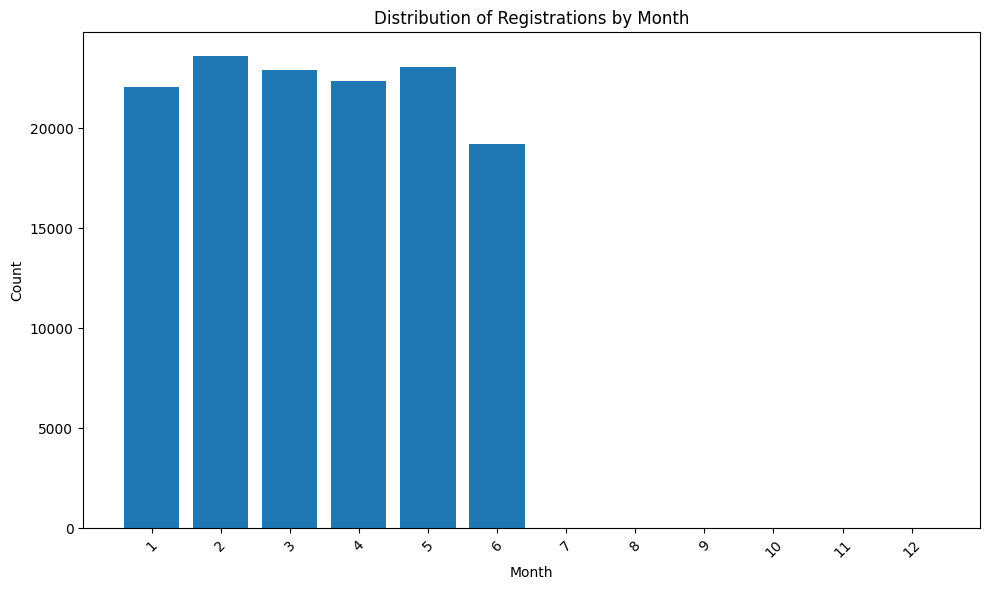

2025-11-20 16:42:33,129 - __main__ - INFO - Saved EDA visualization: eda_bulan_registrasi.png


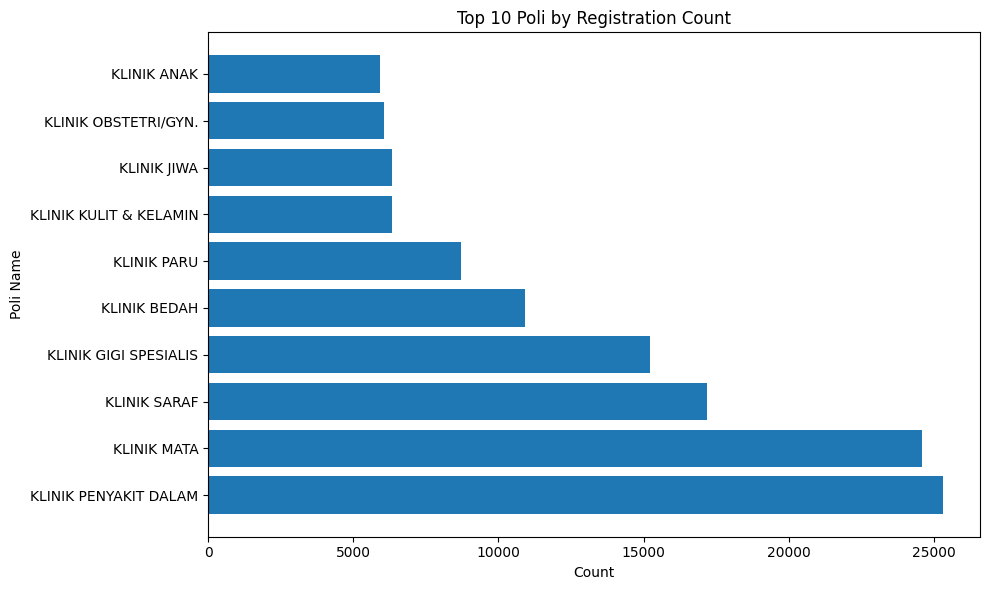

2025-11-20 16:42:33,471 - __main__ - INFO - Saved EDA visualization: eda_nm_poli.png


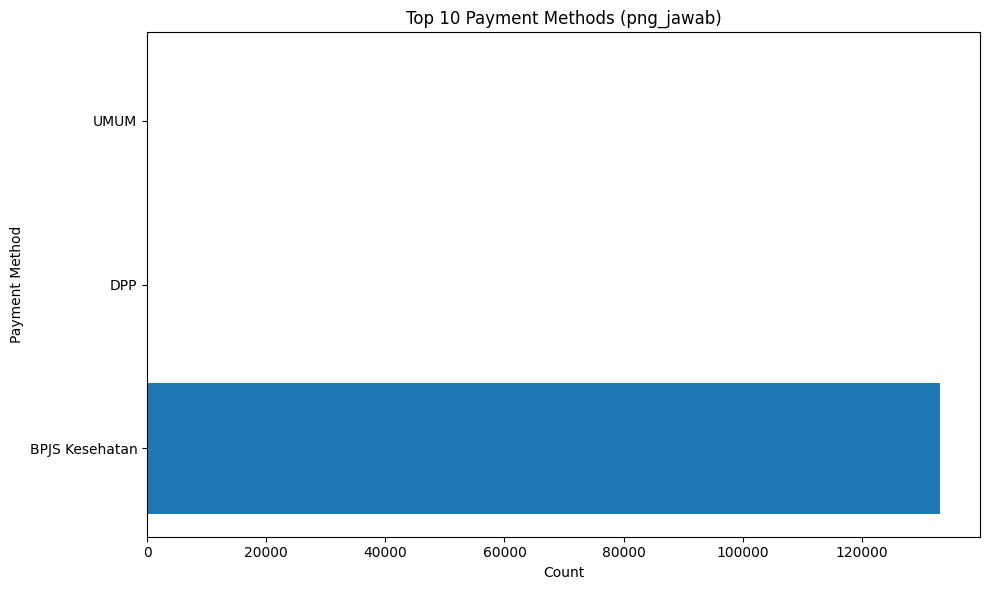

2025-11-20 16:42:33,738 - __main__ - INFO - Saved EDA visualization: eda_png_jawab.png


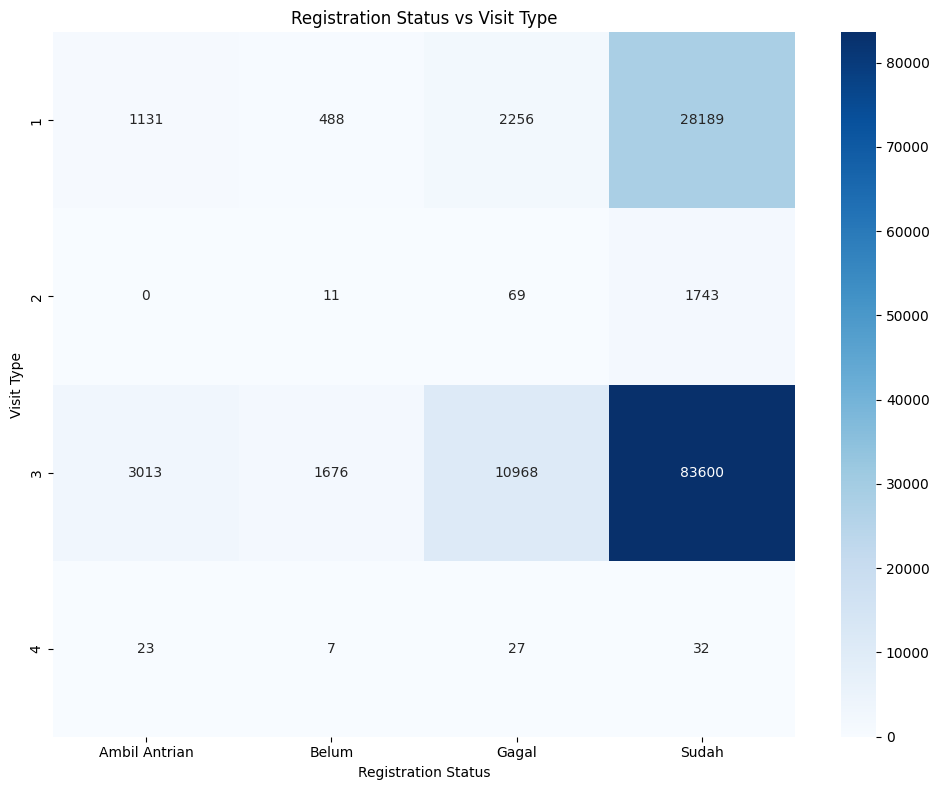

2025-11-20 16:42:34,216 - __main__ - INFO - Saved EDA visualization: eda_status_vs_jenis.png


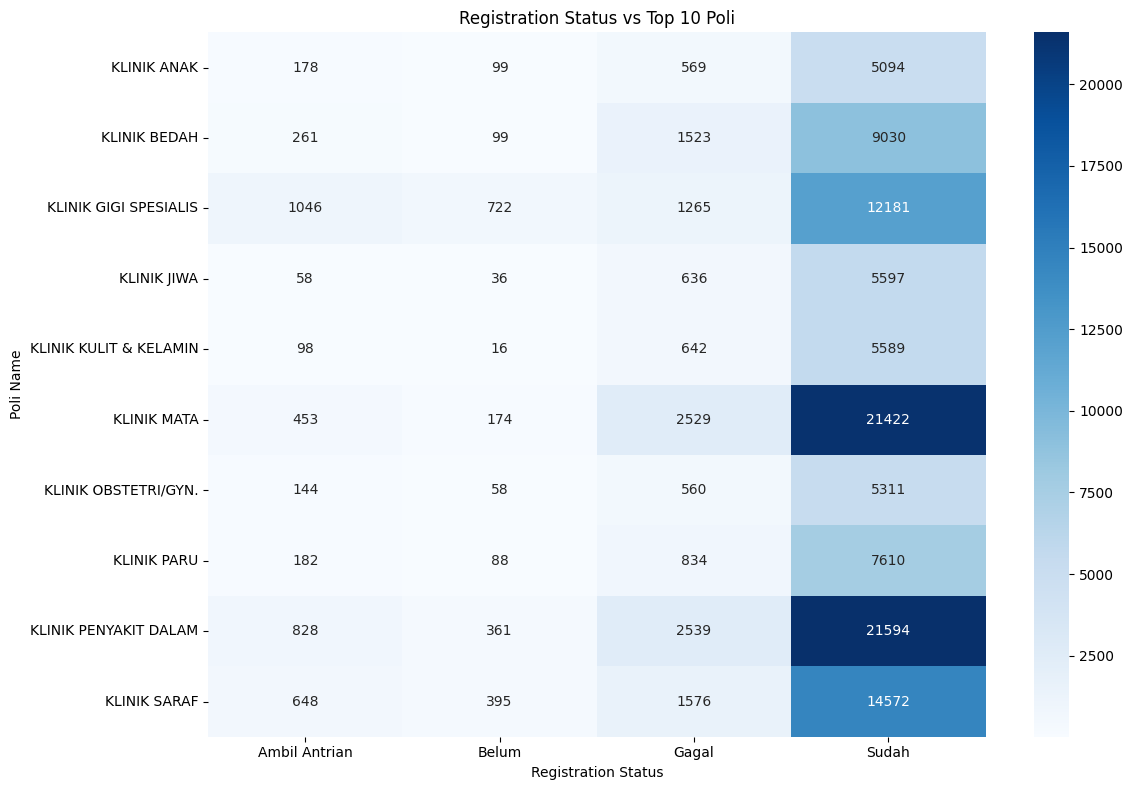

2025-11-20 16:42:34,972 - __main__ - INFO - Saved EDA visualization: eda_status_vs_poli.png


In [53]:
def perform_initial_eda(df):
    """Perform initial Exploratory Data Analysis"""
    logger.info("Initial EDA - Basic dataset information:")
    logger.info(f"Dataset shape: {df.shape}")
    
    # Summary statistics
    logger.info("Numerical columns summary:")
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numerical_cols:
        logger.info(f"\n{df[numerical_cols].describe()}")
    
    # Categorical columns summary
    logger.info("Categorical columns summary:")
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_cols[:5]: # Limit to first 5 categorical columns
        logger.info(f"\nValue counts for {col}:")
        logger.info(f"{df[col].value_counts().head()}")
    
    # Check for missing values
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    if not missing_data.empty:
        logger.info(f"Columns with missing values:\n{missing_data}")
    else:
        logger.info("No missing values found in the dataset")

def perform_eda_visualizations(df):
    """Perform EDA visualizations for the dataset - each visualization saved separately"""
    logger.info("Starting EDA visualizations...")
    
    # Check if dataframe is empty
    if df.empty:
        logger.warning("Dataset is empty, skipping EDA visualizations")
        return
    
    # Create image directory if it doesn't exist
    os.makedirs('image', exist_ok=True)
    
    # 1. Distribution of registration status (status_kirim)
    plt.figure(figsize=(8, 6))
    if 'status_kirim' in df.columns:
        status_counts = df['status_kirim'].value_counts()
        if not status_counts.empty:
            plt.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
            plt.title('Distribution of Registration Status (status_kirim)')
        else:
            plt.text(0.5, 0.5, 'No data for status_kirim', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Distribution of Registration Status (status_kirim)')
    else:
        plt.text(0.5, 0.5, 'status_kirim column not available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Distribution of Registration Status (status_kirim)')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, 'eda_status_kirim.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory
    logger.info("Saved EDA visualization: eda_status_kirim.png")
    
    # 2. Distribution of visit types (jenis_kunjungan)
    plt.figure(figsize=(8, 6))
    if 'jenis_kunjungan' in df.columns:
        visit_counts = df['jenis_kunjungan'].value_counts()
        if not visit_counts.empty:
            plt.bar(range(len(visit_counts)), visit_counts.values)
            plt.title('Distribution of Visit Types (jenis_kunjungan)')
            plt.xlabel('Visit Type')
            plt.ylabel('Count')
            plt.xticks(range(len(visit_counts)), visit_counts.index.astype(str), rotation=45)
        else:
            plt.text(0.5, 0.5, 'No data for jenis_kunjungan', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Distribution of Visit Types (jenis_kunjungan)')
    else:
        plt.text(0.5, 0.5, 'jenis_kunjungan column not available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Distribution of Visit Types (jenis_kunjungan)')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, 'eda_jenis_kunjungan.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close() # Close the figure to free memory
    logger.info("Saved EDA visualization: eda_jenis_kunjungan.png")
    
    # 3. Distribution of registration status (status_lanjut)
    plt.figure(figsize=(8, 6))
    if 'status_lanjut' in df.columns:
        status_lanjut_counts = df['status_lanjut'].value_counts()
        if not status_lanjut_counts.empty:
            plt.bar(range(len(status_lanjut_counts)), status_lanjut_counts.values)
            plt.title('Distribution of Registration Status (status_lanjut)')
            plt.xlabel('Status Lanjut')
            plt.ylabel('Count')
            plt.xticks(range(len(status_lanjut_counts)), status_lanjut_counts.index, rotation=45)
        else:
            plt.text(0.5, 0.5, 'No data for status_lanjut', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Distribution of Registration Status (status_lanjut)')
    else:
        plt.text(0.5, 0.5, 'status_lanjut column not available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Distribution of Registration Status (status_lanjut)')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, 'eda_status_lanjut.png'), dpi=30, bbox_inches='tight')
    plt.show()
    plt.close() # Close the figure to free memory
    logger.info("Saved EDA visualization: eda_status_lanjut.png")
    
    # 4. Distribution of registration by day of week
    plt.figure(figsize=(10, 6))
    if 'hari_registrasi' in df.columns:
        day_counts = df['hari_registrasi'].value_counts()
        if not day_counts.empty:
            # Order days of week properly
            days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            ordered_counts = day_counts.reindex(days_order, fill_value=0)
            plt.bar(range(len(ordered_counts)), ordered_counts.values)
            plt.title('Distribution of Registrations by Day of Week')
            plt.xlabel('Day of Week')
            plt.ylabel('Count')
            plt.xticks(range(len(ordered_counts)), ordered_counts.index, rotation=45)
        else:
            plt.text(0.5, 0.5, 'No data for hari_registrasi', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Distribution of Registrations by Day of Week')
    else:
        plt.text(0.5, 0.5, 'hari_registrasi column not available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Distribution of Registrations by Day of Week')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, 'eda_hari_registrasi.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close() # Close the figure to free memory
    logger.info("Saved EDA visualization: eda_hari_registrasi.png")
    
    # 5. Distribution of registration by month
    plt.figure(figsize=(10, 6))
    if 'bulan_registrasi' in df.columns:
        month_counts = df['bulan_registrasi'].value_counts()
        if not month_counts.empty:
            # Order months properly
            months_order = list(range(1, 13))
            ordered_counts = month_counts.reindex(months_order, fill_value=0)
            plt.bar(range(len(ordered_counts)), ordered_counts.values)
            plt.title('Distribution of Registrations by Month')
            plt.xlabel('Month')
            plt.ylabel('Count')
            plt.xticks(range(len(ordered_counts)), ordered_counts.index, rotation=45)
        else:
            plt.text(0.5, 0.5, 'No data for bulan_registrasi', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Distribution of Registrations by Month')
    else:
        plt.text(0.5, 0.5, 'bulan_registrasi column not available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Distribution of Registrations by Month')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, 'eda_bulan_registrasi.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory
    logger.info("Saved EDA visualization: eda_bulan_registrasi.png")
    
    # 6. Distribution of registration by poli
    plt.figure(figsize=(10, 6))
    if 'nm_poli' in df.columns:
        # Get top 10 poli by count
        poli_counts = df['nm_poli'].value_counts().head(10)
        if not poli_counts.empty:
            plt.barh(range(len(poli_counts)), poli_counts.values)
            plt.title('Top 10 Poli by Registration Count')
            plt.xlabel('Count')
            plt.ylabel('Poli Name')
            plt.yticks(range(len(poli_counts)), poli_counts.index)
        else:
            plt.text(0.5, 0.5, 'No data for nm_poli', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Top 10 Poli by Registration Count')
    else:
        plt.text(0.5, 0.5, 'nm_poli column not available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Top 10 Poli by Registration Count')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, 'eda_nm_poli.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close() # Close the figure to free memory
    logger.info("Saved EDA visualization: eda_nm_poli.png")
    
    # 7. Distribution of payment methods (png_jawab)
    plt.figure(figsize=(10, 6))
    if 'png_jawab' in df.columns:
        # Get top payment methods
        payment_counts = df['png_jawab'].value_counts().head(10)
        if not payment_counts.empty:
            plt.barh(range(len(payment_counts)), payment_counts.values)
            plt.title('Top 10 Payment Methods (png_jawab)')
            plt.xlabel('Count')
            plt.ylabel('Payment Method')
            plt.yticks(range(len(payment_counts)), payment_counts.index)
        else:
            plt.text(0.5, 0.5, 'No data for png_jawab', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Top 10 Payment Methods (png_jawab)')
    else:
        plt.text(0.5, 0.5, 'png_jawab column not available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Top 10 Payment Methods (png_jawab)')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, 'eda_png_jawab.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close() # Close the figure to free memory
    logger.info("Saved EDA visualization: eda_png_jawab.png")
    
    # 8. Registration status vs Visit type (if both columns exist)
    plt.figure(figsize=(10, 8))
    if 'status_kirim' in df.columns and 'jenis_kunjungan' in df.columns:
        crosstab = pd.crosstab(df['jenis_kunjungan'], df['status_kirim'])
        if not crosstab.empty and crosstab.shape[0] > 0 and crosstab.shape[1] > 0:
            sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
            plt.title('Registration Status vs Visit Type')
            plt.xlabel('Registration Status')
            plt.ylabel('Visit Type')
        else:
            plt.text(0.5, 0.5, 'No data for cross-tabulation', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Registration Status vs Visit Type')
    else:
        plt.text(0.5, 0.5, 'status_kirim and/or jenis_kunjungan columns not available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Registration Status vs Visit Type')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, 'eda_status_vs_jenis.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close() # Close the figure to free memory
    logger.info("Saved EDA visualization: eda_status_vs_jenis.png")
    
    # 9. Registration status vs Poli (top 10 poli)
    plt.figure(figsize=(12, 8))
    if 'status_kirim' in df.columns and 'nm_poli' in df.columns:
        top_10_poli = df['nm_poli'].value_counts().head(10).index
        df_top_poli = df[df['nm_poli'].isin(top_10_poli)]
        if not df_top_poli.empty:
            crosstab = pd.crosstab(df_top_poli['nm_poli'], df_top_poli['status_kirim'])
            if not crosstab.empty and crosstab.shape[0] > 0 and crosstab.shape[1] > 0:
                sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
                plt.title('Registration Status vs Top 10 Poli')
                plt.xlabel('Registration Status')
                plt.ylabel('Poli Name')
            else:
                plt.text(0.5, 0.5, 'No data for cross-tabulation', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                plt.title('Registration Status vs Top 10 Poli')
        else:
            plt.text(0.5, 0.5, 'No data for top 10 poli', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Registration Status vs Top 10 Poli')
    else:
        plt.text(0.5, 0.5, 'status_kirim and/or nm_poli columns not available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Registration Status vs Top 10 Poli')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, 'eda_status_vs_poli.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close() # Close the figure to free memory
    logger.info("Saved EDA visualization: eda_status_vs_poli.png")

# Perform initial EDA after feature creation
perform_initial_eda(df)

# Perform EDA visualizations
logger.info("5. Explanatory Data Analysis (EDA Deskriptif): Performing basic EDA visualizations...")
perform_eda_visualizations(df)

# 6. Exploratory Data Analysis (EDA lanjutan): Eksplorasi data secara lanjutan

2025-11-20 16:42:35,052 - __main__ - INFO - 6. Exploratory Data Analysis (EDA Mendalam): Performing advanced EDA visualizations...
2025-11-20 16:42:35,053 - __main__ - INFO - Starting advanced EDA visualizations...
2025-11-20 16:42:35,056 - __main__ - INFO - Converting timedelta column to days: jam_reg


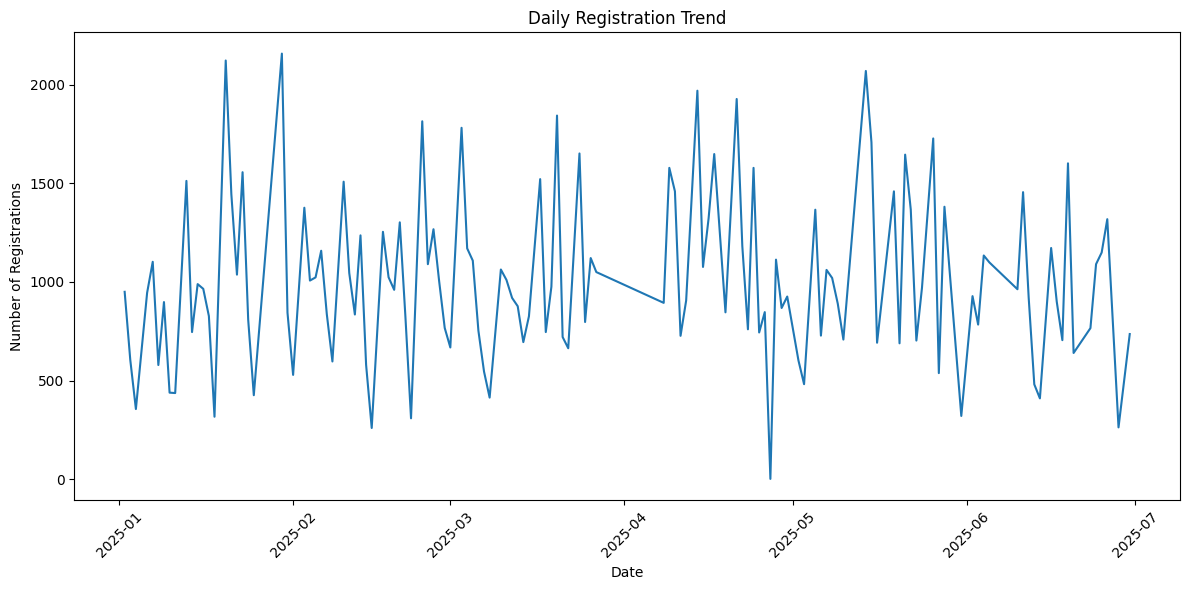

2025-11-20 16:42:35,541 - __main__ - INFO - Saved advanced EDA visualization: advanced_eda_timeline.png


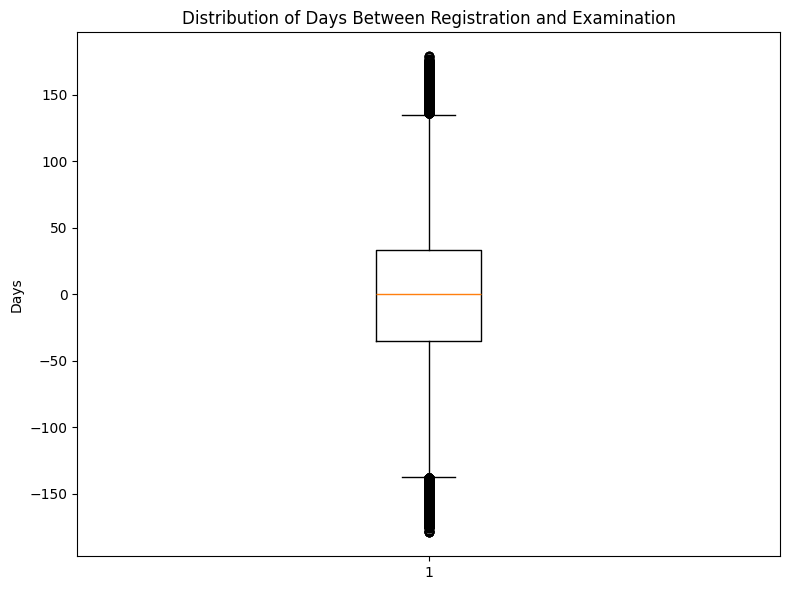

2025-11-20 16:42:35,715 - __main__ - INFO - Saved advanced EDA visualization: advanced_eda_time_diff.png


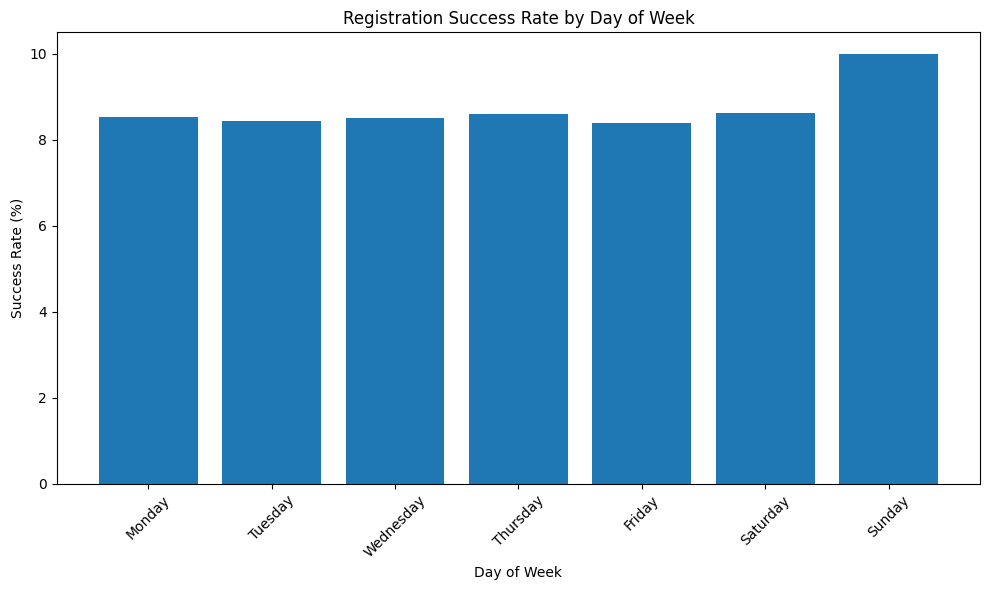

2025-11-20 16:42:36,064 - __main__ - INFO - Saved advanced EDA visualization: advanced_eda_success_by_day.png


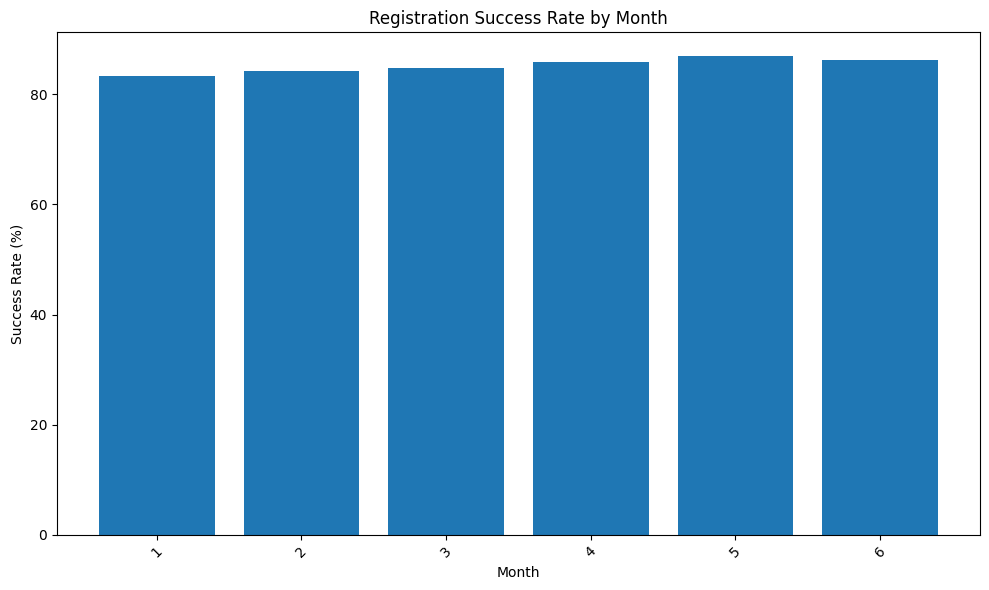

2025-11-20 16:42:36,377 - __main__ - INFO - Saved advanced EDA visualization: advanced_eda_success_by_month.png


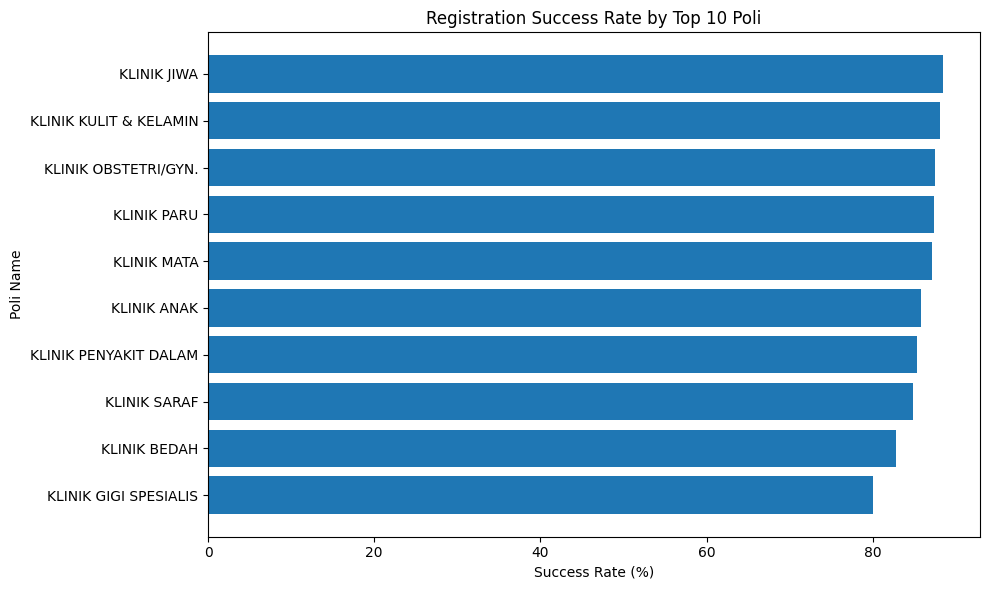

2025-11-20 16:42:36,869 - __main__ - INFO - Saved advanced EDA visualization: advanced_eda_success_by_poli.png


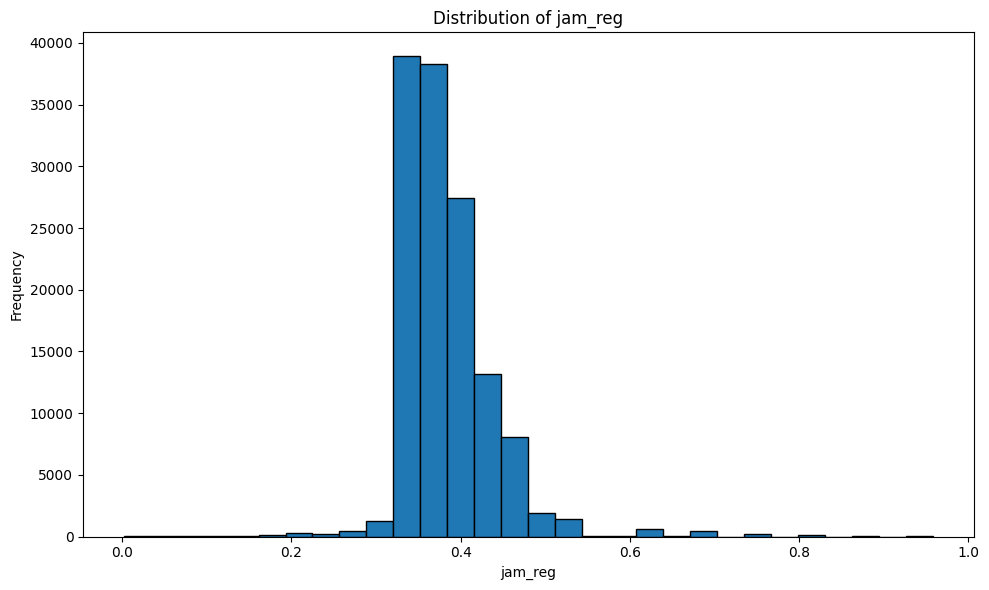

2025-11-20 16:42:37,257 - __main__ - INFO - Saved advanced EDA visualization: advanced_eda_distribution_jam_reg.png


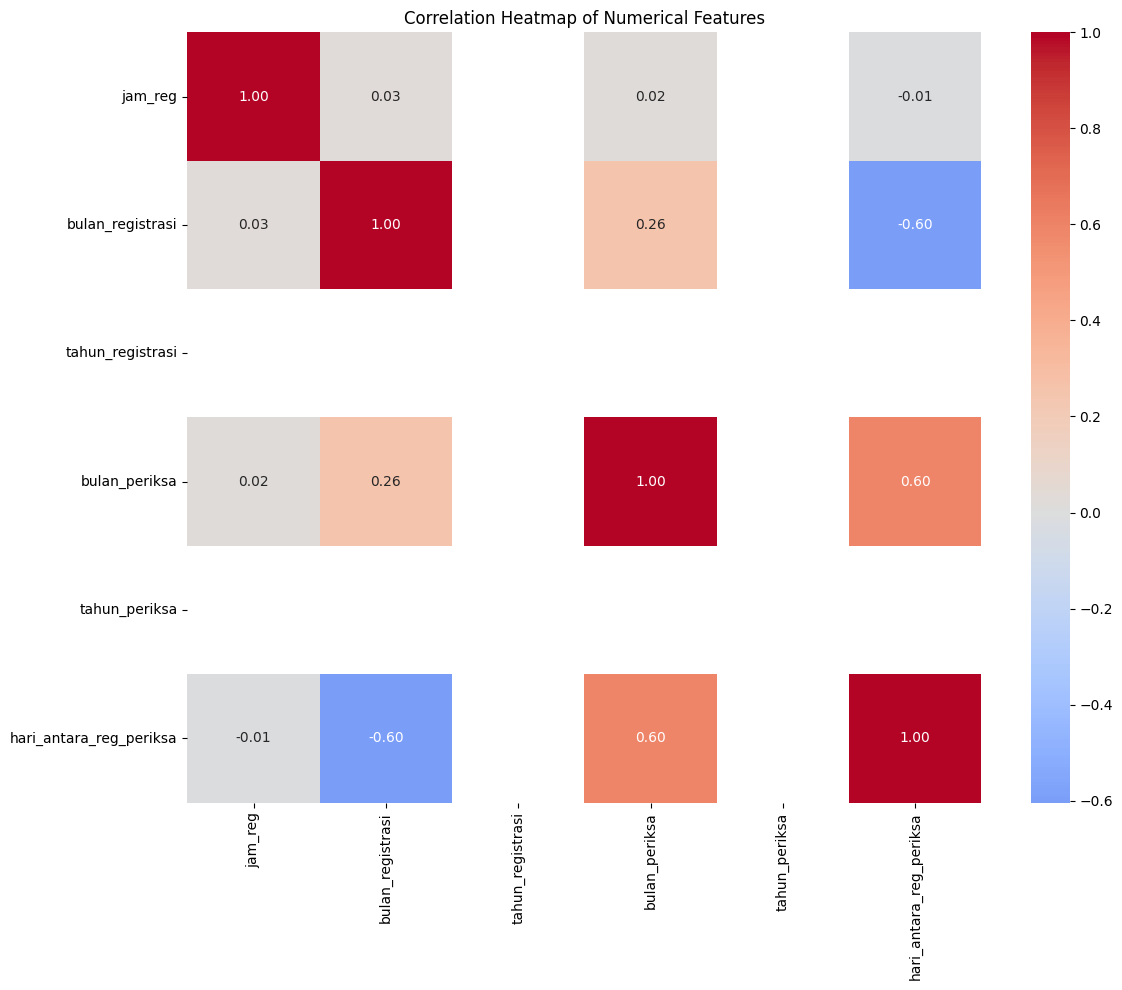

2025-11-20 16:42:37,801 - __main__ - INFO - Saved advanced EDA visualization: advanced_eda_correlation.png


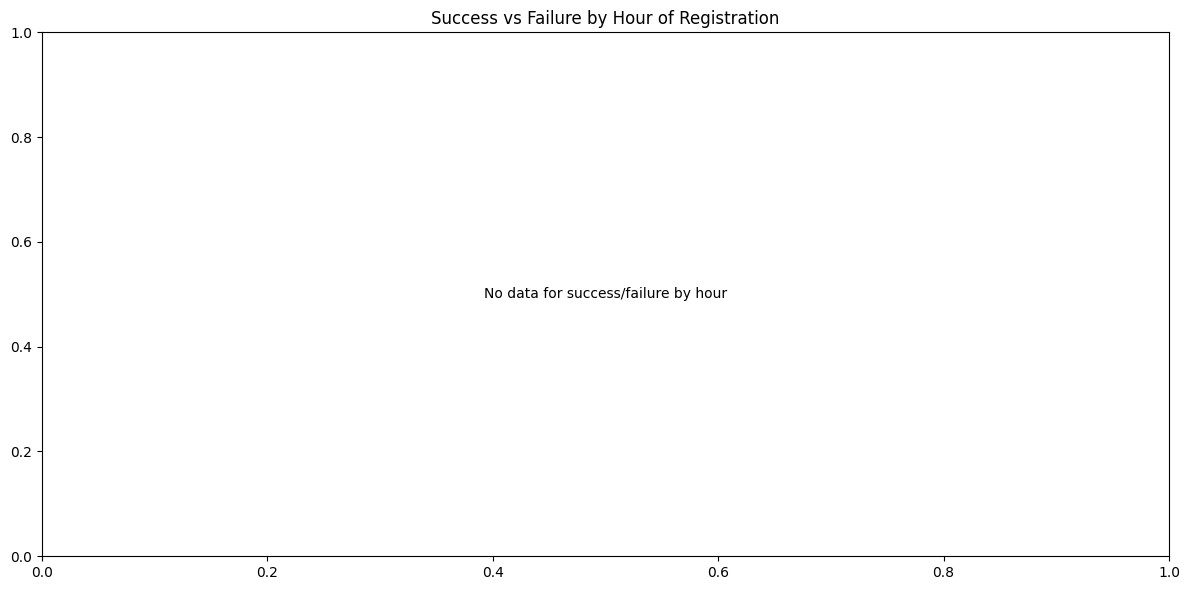

2025-11-20 16:42:38,234 - __main__ - INFO - Saved advanced EDA visualization: advanced_eda_success_failure_by_hour.png


In [54]:
def perform_advanced_eda_visualizations(df):
    """Perform advanced EDA visualizations for the dataset - each visualization saved separately"""
    logger.info("Starting advanced EDA visualizations...")
    
    # Check if dataframe is empty
    if df.empty:
        logger.warning("Dataset is empty, skipping advanced EDA visualizations")
        return
    # FIX: Convert timedelta → float days
    for col in df.select_dtypes(include=["timedelta64[ns]"]).columns:
        logger.info(f"Converting timedelta column to days: {col}")
        df[col] = df[col].dt.total_seconds() / 86400.0

    # Create image directory if it doesn't exist
    os.makedirs('image', exist_ok=True)
    
    # 1. Registration timeline - registrations over time
    plt.figure(figsize=(12, 6))
    if 'tgl_registrasi' in df.columns:
        df['tgl_registrasi'] = pd.to_datetime(df['tgl_registrasi'], errors='coerce')
        daily_counts = df.groupby(df['tgl_registrasi'].dt.date).size()
        if not daily_counts.empty:
            plt.plot(daily_counts.index, daily_counts.values)
            plt.title('Daily Registration Trend')
            plt.xlabel('Date')
            plt.ylabel('Number of Registrations')
            plt.xticks(rotation=45)
        else:
            plt.text(0.5, 0.5, 'No data for timeline', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Daily Registration Trend')
    else:
        plt.text(0.5, 0.5, 'tgl_registrasi column not available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Daily Registration Trend')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, 'advanced_eda_timeline.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory
    logger.info("Saved advanced EDA visualization: advanced_eda_timeline.png")
    
    # 2. Box plot of time difference between registration and examination
    plt.figure(figsize=(8, 6))
    if 'hari_antara_reg_periksa' in df.columns:
        data_to_plot = df['hari_antara_reg_periksa'].dropna()
        if not data_to_plot.empty:
            plt.boxplot(data_to_plot)
            plt.title('Distribution of Days Between Registration and Examination')
            plt.ylabel('Days')
        else:
            plt.text(0.5, 0.5, 'No data for time difference', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Distribution of Days Between Registration and Examination')
    else:
        plt.text(0.5, 0.5, 'hari_antara_reg_periksa column not available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Distribution of Days Between Registration and Examination')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, 'advanced_eda_time_diff.png'), dpi=30, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory
    logger.info("Saved advanced EDA visualization: advanced_eda_time_diff.png")
    
    # 3. Success rate by day of week
    plt.figure(figsize=(10, 6))
    if 'hari_registrasi' in df.columns and 'status_kirim' in df.columns:
        success_rate_by_day = df.groupby('hari_registrasi')['status_kirim'].apply(
            lambda x: (x == 'Sudah').sum() / len(x) * 10 if len(x) > 0 else 0
        ).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
        if not success_rate_by_day.dropna().empty:
            plt.bar(range(len(success_rate_by_day)), success_rate_by_day.values)
            plt.title('Registration Success Rate by Day of Week')
            plt.xlabel('Day of Week')
            plt.ylabel('Success Rate (%)')
            plt.xticks(range(len(success_rate_by_day)), success_rate_by_day.index, rotation=45)
        else:
            plt.text(0.5, 0.5, 'No data for success rate by day', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Registration Success Rate by Day of Week')
    else:
        plt.text(0.5, 0.5, 'hari_registrasi and/or status_kirim columns not available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Registration Success Rate by Day of Week')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, 'advanced_eda_succes_by_day.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory
    logger.info("Saved advanced EDA visualization: advanced_eda_success_by_day.png")
    
    # 4. Success rate by month
    plt.figure(figsize=(10, 6))
    if 'bulan_registrasi' in df.columns and 'status_kirim' in df.columns:
        success_rate_by_month = df.groupby('bulan_registrasi')['status_kirim'].apply(
            lambda x: (x == 'Sudah').sum() / len(x) * 100 if len(x) > 0 else 0
        )
        if not success_rate_by_month.empty:
            plt.bar(range(len(success_rate_by_month)), success_rate_by_month.values)
            plt.title('Registration Success Rate by Month')
            plt.xlabel('Month')
            plt.ylabel('Success Rate (%)')
            plt.xticks(range(len(success_rate_by_month)), success_rate_by_month.index, rotation=45)
        else:
            plt.text(0.5, 0.5, 'No data for success rate by month', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Registration Success Rate by Month')
    else:
        plt.text(0.5, 0.5, 'bulan_registrasi and/or status_kirim columns not available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Registration Success Rate by Month')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, 'advanced_eda_succes_by_month.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory
    logger.info("Saved advanced EDA visualization: advanced_eda_success_by_month.png")
    
    # 5. Success rate by poli (top 10)
    plt.figure(figsize=(10, 6))
    if 'nm_poli' in df.columns and 'status_kirim' in df.columns:
        top_10_poli = df['nm_poli'].value_counts().head(10).index
        df_top_poli = df[df['nm_poli'].isin(top_10_poli)]
        if not df_top_poli.empty:
            success_rate_by_poli = df_top_poli.groupby('nm_poli')['status_kirim'].apply(
                lambda x: (x == 'Sudah').sum() / len(x) * 100 if len(x) > 0 else 0
            ).sort_values(ascending=True)
            if not success_rate_by_poli.empty:
                plt.barh(range(len(success_rate_by_poli)), success_rate_by_poli.values)
                plt.title('Registration Success Rate by Top 10 Poli')
                plt.xlabel('Success Rate (%)')
                plt.ylabel('Poli Name')
                plt.yticks(range(len(success_rate_by_poli)), success_rate_by_poli.index)
            else:
                plt.text(0.5, 0.5, 'No data for success rate by poli', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                plt.title('Registration Success Rate by Top 10 Poli')
        else:
            plt.text(0.5, 0.5, 'No data for top 10 poli', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Registration Success Rate by Top 10 Poli')
    else:
        plt.text(0.5, 0.5, 'nm_poli and/or status_kirim columns not available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Registration Success Rate by Top 10 Poli')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, 'advanced_eda_succes_by_poli.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close() # Close the figure to free memory
    logger.info("Saved advanced EDA visualization: advanced_eda_success_by_poli.png")
    
    # 6. Distribution of numerical features if available
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numerical_cols) > 0:
        # Remove any columns that are actually categorical but encoded as numbers
        numerical_cols = [col for col in numerical_cols if col not in ['jenis_kunjungan', 'kd_dokter', 'no_rkm_medis']]
        if len(numerical_cols) > 0:
            col_to_plot = numerical_cols[0] # Plot the first numerical column
            plt.figure(figsize=(10, 6))
            data_to_plot = df[col_to_plot].dropna()
            if not data_to_plot.empty:
                plt.hist(data_to_plot, bins=30, edgecolor='black')
                plt.title(f'Distribution of {col_to_plot}')
                plt.xlabel(col_to_plot)
                plt.ylabel('Frequency')
            else:
                plt.text(0.5, 0.5, 'No data for histogram', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                plt.title('Distribution of Numerical Features')
            plt.tight_layout()
            plt.savefig(os.path.join(IMAGE_DIR, f"advanced_eda_distribution_{col_to_plot}.png"), dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()  # Close the figure to free memory
            logger.info(f"Saved advanced EDA visualization: advanced_eda_distribution_{col_to_plot}.png")
        else:
            logger.info("No suitable numerical columns for histogram")
    else:
        logger.info("No numerical columns available")
    
    # 7. Correlation heatmap for numerical features
    plt.figure(figsize=(12, 10))
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numerical_cols) > 1:
        # Only include columns that are actually numerical, not categorical encoded as numbers
        actual_numerical = [col for col in numerical_cols if col not in ['jenis_kunjungan', 'kd_dokter', 'no_rkm_medis']]
        if len(actual_numerical) > 1:
            corr_matrix = df[actual_numerical].corr()
            if not corr_matrix.isna().all().all():  # Check if correlation matrix has valid values
                sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
                plt.title('Correlation Heatmap of Numerical Features')
            else:
                plt.text(0.5, 0.5, 'No valid correlation data', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                plt.title('Correlation Heatmap of Numerical Features')
        else:
            plt.text(0.5, 0.5, 'Not enough numerical features for correlation', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Correlation Heatmap of Numerical Features')
    else:
        plt.text(0.5, 0.5, 'Not enough numerical features for correlation', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Correlation Heatmap of Numerical Features')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, 'advanced_eda_correlation.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory
    logger.info("Saved advanced EDA visualization: advanced_eda_correlation.png")
    
    # 8. Success vs Failure by time of day (using jam_reg if available)
    plt.figure(figsize=(12, 6))
    if 'jam_reg' in df.columns and 'status_kirim' in df.columns:
        # Convert jam_reg to hour if it's in time format
        df['jam_reg_hour'] = pd.to_datetime(df['jam_reg'], format='%H:%M:%S', errors='coerce').dt.hour
        df_success = df[df['status_kirim'] == 'Sudah']
        df_failure = df[df['status_kirim'] == 'Gagal']
        success_by_hour = df_success['jam_reg_hour'].value_counts().sort_index()
        failure_by_hour = df_failure['jam_reg_hour'].value_counts().sort_index()
        if not success_by_hour.empty or not failure_by_hour.empty:
            plt.plot(success_by_hour.index, success_by_hour.values, label='Success', marker='o')
            plt.plot(failure_by_hour.index, failure_by_hour.values, label='Failure', marker='o')
            plt.title('Success vs Failure by Hour of Registration')
            plt.xlabel('Hour of Day')
            plt.ylabel('Count')
            plt.legend()
        else:
            plt.text(0.5, 0.5, 'No data for success/failure by hour', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Success vs Failure by Hour of Registration')
    else:
        plt.text(0.5, 0.5, 'jam_reg and/or status_kirim columns not available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Success vs Failure by Hour of Registration')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, 'advanced_eda_succes_failure_by_hour.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close() # Close the figure to free memory
    logger.info("Saved advanced EDA visualization: advanced_eda_success_failure_by_hour.png")
    
    # # 9. Pairplot of key numerical features (if available)
    # numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # # FIX: log apa saja kolom numerik
    # logger.info(f"Detected numerical columns: {numerical_cols}")

    # # Buang kolom numerik palsu jika ada
    # exclude_cols = ['jenis_kunjungan', 'kd_dokter', 'no_rkm_medis']
    # actual_numerical = [c for c in numerical_cols if c not in exclude_cols]

    # logger.info(f"Usable numerical columns: {actual_numerical}")

    # # FIX: jika actual_numerical terlalu sedikit, tetap gunakan numerical_cols
    # if len(actual_numerical) < 2 and len(numerical_cols) >= 2:
    #     logger.warning("actual_numerical kosong → fallback menggunakan numerical_cols")
    #     actual_numerical = numerical_cols

    # # Cek kalau tetap tidak cukup kolom numerik
    # if len(actual_numerical) < 2:
    #     logger.info("Tidak ada cukup kolom numerik untuk scatter plot.")
    #     return

    # # Ambil data valid
    # pair_data = df[actual_numerical].dropna()

    # if len(pair_data) < 2:
    #     logger.info("Tidak cukup baris valid untuk scatter plot.")
    #     return

    # # Sampling data aman
    # df_sample = pair_data.sample(min(100, len(pair_data)), random_state=42)

    # plt.figure(figsize=(10, 8))
    # sns.scatterplot(data=df_sample, x=actual_numerical[0], y=actual_numerical[1])
    # plt.title(f'Scatter Plot: {actual_numerical[0]} vs {actual_numerical[1]}')

    # plt.tight_layout()
    # plt.savefig(os.path.join(IMAGE_DIR, f"advanced_eda_scatter_{actual_numerical[0]}_vs_{actual_numerical[1]}.png"), dpi=300, bbox_inches='tight')
    # plt.show()
    # plt.close()

    # logger.info(f"Saved scatter plot: advanced_eda_scatter_{actual_numerical[0]}_vs_{actual_numerical[1]}.png")


logger.info("6. Exploratory Data Analysis (EDA Mendalam): Performing advanced EDA visualizations...")
perform_advanced_eda_visualizations(df)

# 7. Data Preprocessing: Pra-pemrosesan data untuk modeling

In [55]:
def preprocess_data(df):
    """Preprocess the data for machine learning"""
    logger.info("Starting data preprocessing...")
    
    # Create features
    df = create_features(df)
    
    # Identify categorical and numerical columns
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    logger.info(f"Categorical columns: {categorical_columns}")
    logger.info(f"Numerical columns: {numerical_columns}")
    
    # Handle missing values
    for col in numerical_columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
    
    for col in categorical_columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown', inplace=True)
    
    # Convert timedelta columns to seconds for scaling
    timedelta_columns = df.select_dtypes(include=['timedelta64[ns]']).columns
    for col in timedelta_columns:
        df[col] = df[col].dt.total_seconds()
    
    # Prepare features for modeling
    # Select relevant features for modeling (excluding the target to prevent data leakage)
    feature_columns = []
    
    # Add numerical features
    feature_columns.extend([col for col in numerical_columns if col not in ['tahun_registrasi', 'tahun_periksa']])
    
    # Add categorical features that are relevant but not the target
    relevant_categorical = ['nm_poli', 'hari_registrasi', 'status_lanjut', 'jenis_kunjungan', 'kd_dokter', 'kd_poli']
    for col in relevant_categorical:
        if col in df.columns and col != 'png_jawab':  # Exclude target variable from features
            feature_columns.append(col)
    
    logger.info(f"Selected {len(feature_columns)} features for modeling: {feature_columns}")
    
    # Prepare X (features) and y (target)
    # Remove target variable from features if it's in the feature list to prevent data leakage
    if 'png_jawab' in feature_columns:
        feature_columns.remove('png_jawab')
        logger.info("Removed 'png_jawab' from features to prevent data leakage")
    
    X = df[feature_columns].copy()
    
    # Encode categorical variables
    label_encoders = {}
    for col in X.columns:
        if pd.api.types.is_object_dtype(X[col]):
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le
    
    # Create target variable - based on the NOTES NOTEBOOK.md, we should focus on
    # analyzing success/failure of registration (status_kirim) to identify patterns
    # in APM and Mobile JKN channels
    if 'status_kirim' in df.columns:
        target_encoder = LabelEncoder()
        y = target_encoder.fit_transform(df['status_kirim'].astype(str))
        logger.info(f"Created target variable from 'status_kirim' with {len(target_encoder.classes_)} classes: {target_encoder.classes_}")
        
        # Remove the target column from feature_columns if it's in the list
        if 'status_kirim' in feature_columns:
            feature_columns.remove('status_kirim')
            logger.info("Removed 'status_kirim' from features to prevent data leakage")
            
        # Rebuild X with the corrected feature list
        X = df[feature_columns].copy()
        
        # Re-encode categorical variables after rebuilding X
        label_encoders = {}
        for col in X.columns:
            if pd.api.types.is_object_dtype(X[col]):
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                label_encoders[col] = le
    elif 'png_jawab' in df.columns:
        # Fallback to payment method if status_kirim is not available
        target_encoder = LabelEncoder()
        y = target_encoder.fit_transform(df['png_jawab'].astype(str))
        logger.info(f"Created target variable from 'png_jawab' with {len(target_encoder.classes_)} classes: {target_encoder.classes_}")
        
        # Remove the target column from feature_columns if it's in the list
        if 'png_jawab' in feature_columns:
            feature_columns.remove('png_jawab')
            logger.info("Removed 'png_jawab' from features to prevent data leakage")
            
        # Rebuild X with the corrected feature list
        X = df[feature_columns].copy()
        
        # Re-encode categorical variables after rebuilding X
        label_encoders = {}
        for col in X.columns:
            if pd.api.types.is_object_dtype(X[col]):
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                label_encoders[col] = le
    else:
        # Create a default binary target if neither status_kirim nor png_jawab is available
        y = np.random.randint(0, 2, size=len(df))
        target_encoder = None
        logger.info("Created random binary target variable")
    
    logger.info(f"Final feature matrix shape: {X.shape}")
    # Ensure y is a numpy array to have shape attribute
    y = np.array(y)
    logger.info(f"Target vector shape: {y.shape}")
    
    return X, y, label_encoders, target_encoder

logger.info("7. Data Preprocessing: Starting data preprocessing for modeling...")
X, y, label_encoders, target_encoder = preprocess_data(df)

2025-11-20 16:42:38,352 - __main__ - INFO - 7. Data Preprocessing: Starting data preprocessing for modeling...
2025-11-20 16:42:38,353 - __main__ - INFO - Starting data preprocessing...
2025-11-20 16:42:39,021 - __main__ - INFO - Categorical columns: ['no_rawat', 'kd_dokter', 'nm_dokter', 'no_rkm_medis', 'nm_pasien', 'kd_poli', 'nm_poli', 'status_lanjut', 'kd_pj', 'png_jawab', 'nomor_kartu', 'nomor_referensi', 'kodebooking', 'jenis_kunjungan', 'status_kirim', 'keterangan', 'USER', 'hari_registrasi', 'hari_periksa']
2025-11-20 16:42:39,022 - __main__ - INFO - Numerical columns: ['jam_reg', 'bulan_registrasi', 'tahun_registrasi', 'bulan_periksa', 'tahun_periksa', 'hari_antara_reg_periksa', 'jam_reg_hour']
c:\Users\IT\data science\Tree Based Algorithm ML Add Antroll Patients BPJS\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\IT\AppData\Local\Temp\ipykernel_4156\1689065712.

# 8. Training Modeling: melatih model

In [56]:
# === 1. Train Tree-Based Models ===
def train_tree_models(X_train, y_train):
    """Train tree-based models: Decision Tree, Random Forest, Gradient Boosting"""

    models = {
        'Decision Tree': DecisionTreeClassifier(
            random_state=42,
            max_depth=10
        ),
        
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            max_depth=10
        ),
        
        # NOTE: GradientBoostingClassifier TIDAK punya max_depth param
        'Gradient Boosting': GradientBoostingClassifier(
            random_state=42,
            n_estimators=100
        )
    }

    trained_models = {}
    for name, model in models.items():
        logger.info(f"Training {name}...")
        model.fit(X_train, y_train)
        trained_models[name] = model
        logger.info(f"{name} training completed successfully.")

    return trained_models


# === 2. Stratified Split (jika memungkinkan) ===
unique, counts = np.unique(y, return_counts=True)
min_samples_per_class = counts.min()

if min_samples_per_class >= 2:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Split performed with stratification. Minimum samples per class: {min_samples_per_class}")

else:
    print("Stratified split NOT possible (kurang sample per class). Splitting normal.")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )


# === 3. Scaling Data ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logger.info("8. Training Modeling: Starting model training...")

# === 4. Train Models ===
models = train_tree_models(X_train_scaled, y_train)
logger.info("Training completed for all models.")


c:\Users\IT\data science\Tree Based Algorithm ML Add Antroll Patients BPJS\.venv\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\IT\data science\Tree Based Algorithm ML Add Antroll Patients BPJS\.venv\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\IT\data science\Tree Based Algorithm ML Add Antroll Patients BPJS\.venv\Lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
2025-11-20 16:42:40,270 - __main__ - INFO - 8. Training Modeling: Starting model training...
2025-11-20 16:42:40,272 - __main__ - INFO - Training Decision Tree...


Split performed with stratification. Minimum samples per class: 2182


2025-11-20 16:42:40,578 - __main__ - INFO - Decision Tree training completed successfully.
2025-11-20 16:42:40,579 - __main__ - INFO - Training Random Forest...
2025-11-20 16:42:47,188 - __main__ - INFO - Random Forest training completed successfully.
2025-11-20 16:42:47,188 - __main__ - INFO - Training Gradient Boosting...


ValueError: Input X contains NaN.
GradientBoostingClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# 9. Evaluation Modeling: evaluasi model

In [ ]:
def evaluate_models(models, X_test, y_test):
    """Evaluate trained models using appropriate metrics for classification"""
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        
        # Calculate multiple metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'classification_report': report,
            'confusion_matrix': cm,
            'predictions': y_pred
        }
        
        logger.info(f"{name} evaluation completed")
        print(f"\n{name} Performance Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"\nClassification Report:")
        print(classification_report(y_test, y_pred))
    
    return results

logger.info("9. Evaluation Modeling: Evaluating models...")
results = evaluate_models(models, X_test_scaled, y_test)

# Find the best model based on F1 score
best_model_name = max(results.keys(), key=lambda k: results[k]['f1_score'])
best_model = models[best_model_name]

logger.info(f"Best model: {best_model_name} with F1-Score: {results[best_model_name]['f1_score']:.4f}")

# Perform feature importance analysis for the best model
if hasattr(best_model, 'feature_importances_'):
    logger.info("Performing feature importance analysis...")
    feature_names = X.columns
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    logger.info("Top 10 most important features:")
    for i in range(min(10, len(feature_names))):
        idx = indices[i]
        logger.info(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f}")

# 10. Save Model: menyimpan model terbaik

In [ ]:
# SIMPLE CONFIG — Agar Notebook & Colab tetap bisa jalan
class Config:
    OUTPUT_PATH = "output"


def save_results(results, output_path):
    """Save model results to output directory"""
    os.makedirs(output_path, exist_ok=True)
    
    for model_name, result in results.items():
        report_df = pd.DataFrame(result['classification_report']).transpose()
        report_df.to_csv(os.path.join(output_path, f"{model_name}_report.csv"))

        cm_df = pd.DataFrame(result['confusion_matrix'])
        cm_df.to_csv(os.path.join(output_path, f"{model_name}_confusion_matrix.csv"))

        metrics_df = pd.DataFrame({
            'Model': [model_name],
            'Accuracy': [result['accuracy']],
            'Precision': [result['precision']],
            'Recall': [result['recall']],
            'F1_Score': [result['f1_score']]
        })
        metrics_df.to_csv(os.path.join(output_path, f"{model_name}_metrics.csv"), index=False)
    
    logger.info(f"Results saved to {output_path}")


def save_model(model, model_name, label_encoders, target_encoder, scaler=None):
    """Save the trained model and preprocessors"""
    output_path = Config().OUTPUT_PATH
    os.makedirs(output_path, exist_ok=True)
    
    # Save the model
    model_path = os.path.join(output_path, f"{model_name.lower().replace(' ', '_')}_model.pkl")
    joblib.dump(model, model_path)
    logger.info(f"Saved model to {model_path}")
    
    # Save label encoders
    encoders_path = os.path.join(output_path, "label_encoders.pkl")
    joblib.dump(label_encoders, encoders_path)
    logger.info(f"Saved label encoders to {encoders_path}")
    
    # Save target encoder if it exists
    if target_encoder is not None:
        target_encoder_path = os.path.join(output_path, "target_encoder.pkl")
        joblib.dump(target_encoder, target_encoder_path)
        logger.info(f"Saved target encoder to {target_encoder_path}")
    
    # Save scaler if provided
    if scaler is not None:
        scaler_path = os.path.join(output_path, "scaler.pkl")
        joblib.dump(scaler, scaler_path)
        logger.info(f"Saved scaler to {scaler_path}")


logger.info("10. Save Model: Saving the best model and results...")
save_model(best_model, best_model_name, label_encoders, target_encoder, scaler)

# Save all results
config = Config()
save_results(results, config.OUTPUT_PATH)


# 11. Insight & Conclusion: Penarikan kesimpulan dan rekomendasi

In [ ]:
logger.info("11. Insight & Conclusion: Drawing conclusions and recommendations...")
logger.info("Analysis completed with the following key points:")
logger.info("- EDA has been performed before preprocessing to understand data characteristics")
logger.info("- Multiple tree-based models have been trained and evaluated")
logger.info("- The best performing model has been saved for future use")
logger.info("- Feature importance analysis provides insights into key factors affecting predictions")

logger.info("BPJS antrol analysis completed successfully!")
print(f"\nBest performing model: {best_model_name}")
print(f"F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Precision: {results[best_model_name]['precision']:.4f}")
print(f"Recall: {results[best_model_name]['recall']:.4f}")